In [1]:
import os
import os.path as path
from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as la

from src.structured_random_features.src.models.weights import V1_weights

# Packages for fft and fitting data
from scipy import fftpack as fft
from sklearn.linear_model import Lasso

# Package for importing image representation
from PIL import Image, ImageOps


In [2]:
# 1. Generate random V1 weights

numCell = 100
dim = (30, 30)
cellSize = 5
sparseFreq = 3

W = V1_weights(numCell, dim, cellSize, sparseFreq)

In [3]:
print(W.shape)

(100, 900)


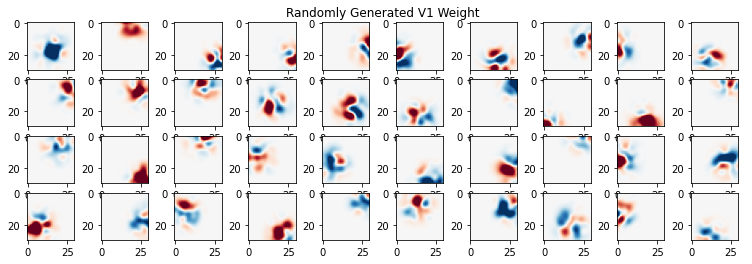

In [4]:
# 2. Plot those V1 weights

fig = plt.figure(figsize = (13, 4))
plt.title('Randomly Generated V1 Weight')
plt.axis('off')
for i in range(40):
    ax = fig.add_subplot(4, 10, i+1)
    cell_rf = W[i]
    cell_rf = cell_rf.reshape(dim)
    plt.imshow(cell_rf, cmap="RdBu")
    plt.clim([-3, 3])
    #plt.axis('off')

In [5]:
W.shape

(100, 900)

In [6]:
# Wx = (lambda)Ux * G
# min ||y-G(Lambda)s||^2 + lambda||s||.

In [7]:
# load size dim image
# reshape to dim[0] * dim[1]
# do:
#W @ x

(64, 104)


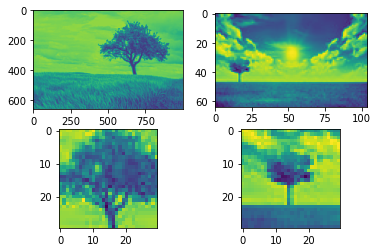

In [8]:
fig = plt.figure()

img_Original1 = Image.open("image/tree.jpg") # Original size(1000, 662)
img_Original1 = ImageOps.grayscale(img_Original1)

img_Original2 = Image.open("image/tree3.jpg") # Original size(64, 104)
img_Original2 = ImageOps.grayscale(img_Original2)
print(np.asarray(img_Original2).shape)

# took 30 X 30 pixel part of tree image at about coord(650, 260)
img1 = Image.open("image/tree_part1.jpg")
img1 = ImageOps.grayscale(img1)
imgArr1 = np.asarray(img1)


# Substitution image in case
img2 = Image.open("image/tree3_part.jpg")
img2 = ImageOps.grayscale(img2)
imgArr2 = np.asarray(img2)

# # of image
numImage = 2

#Show image
ax = fig.add_subplot(2, 2, 1)
plt.imshow(img_Original1)

ax = fig.add_subplot(2, 2, 2)
plt.imshow(img_Original2)

ax = fig.add_subplot(2, 2, 3)
plt.imshow(img1)

ax = fig.add_subplot(2, 2, 4)
plt.imshow(img2)

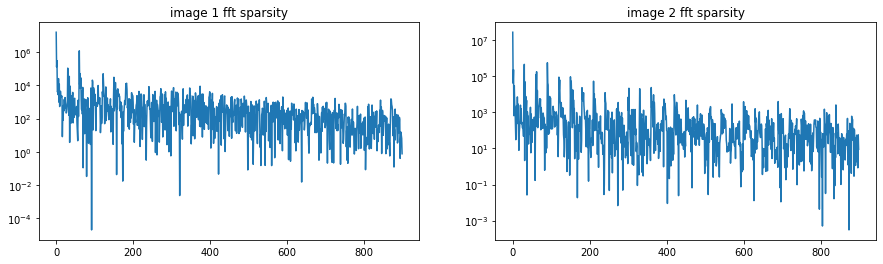

In [9]:
fig = plt.figure(figsize = (15, 4))

# FFT of original image
ax = fig.add_subplot(1, 2, 1)
plt.plot(fft.dctn(imgArr1, norm = 'ortho', axes=[0,1]).ravel() ** 2)
plt.title("image 1 fft sparsity")
ax.set_yscale('log')

ax = fig.add_subplot(1, 2, 2)
plt.plot(fft.dctn(imgArr2, norm = 'ortho', axes=[0,1]).ravel() ** 2)
plt.title("image 2 fft sparsity")
ax.set_yscale('log')

In [10]:
n = 30 # image in (n, n) dimension

imgArr1 = imgArr1.flatten().reshape((900, 1)) #flattens & resize image array into 1 dimension where (900, 1)
imgArr2 = imgArr2.flatten().reshape((900, 1)) #flattens & resize image array into 1 dimension where (900, 1)
print("ImgArr shape: ", imgArr1.shape)

ImgArr shape:  (900, 1)


Text(0.5, 1.0, 'image 2 fft sparsity')

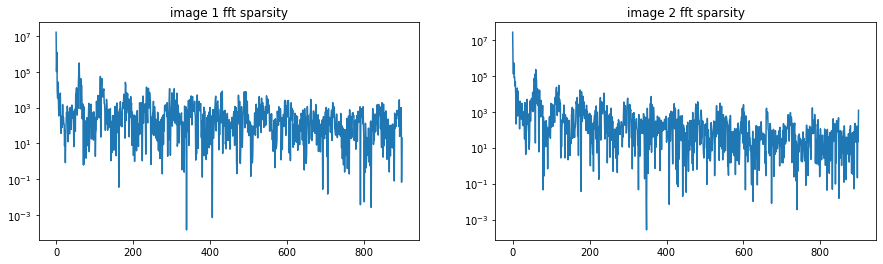

In [15]:
fig = plt.figure(figsize = (15, 4))

# FFT of original image
ax = fig.add_subplot(1, 2, 1)
plt.plot(fft.dctn(imgArr1, norm = 'ortho', axes = [0, 1]).ravel() ** 2)
plt.title("image 1 fft sparsity")
plt.yscale('log')

ax = fig.add_subplot(1, 2, 2)
plt.plot(fft.dctn(imgArr2, norm = 'ortho', axes = [0, 1]).ravel() ** 2)
plt.yscale('log')
plt.title("image 2 fft sparsity")

### Seems like it is sparse enough, Thus I will try to implement original fft onto it to see if it can generate original image

## From y = CΨs, (While considering W ~= C
#### 1.Get y
#### 2. Do WΨ to get theta
#### 3. Lasso to fit thetha with y and get sparse s
#### 4. Reconstruct image

In [16]:
# 1. Some measurement y

# image 1
y1 = W @ imgArr1
y1 = y1.squeeze()

# image 2
y2 = W @ imgArr2
y2 = y2.squeeze()

In [17]:
## 2. WΨ
theta = fft.dctn(W.reshape(numCell, n, n), norm = 'ortho', axes = [1, 2])
theta = theta.reshape(numCell, n*n)
theta.shape


(100, 900)

In [18]:
# Check difference between W and theta
#fig = plt.figure(figsize = (15, 4))
#ax = fig.add_subplot(1, 2, 1)
#plt.plot(theta)
#plt.title("Theta")

#ax = fig.add_subplot(1, 2, 2)
#plt.plot(W)
#plt.title("W")


s1 shape: (900,)
s2 shape: (900,)


Text(0.5, 1.0, 'sparse s2')

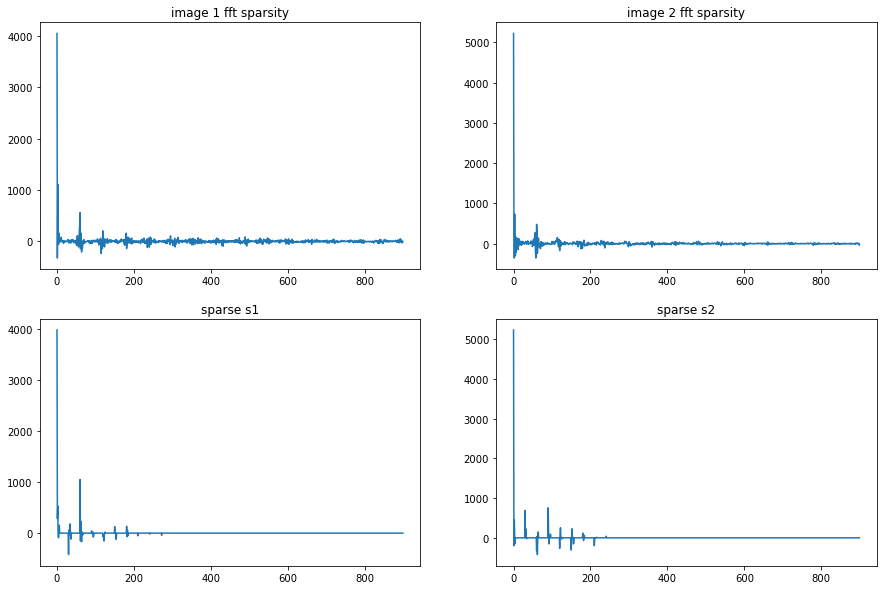

In [19]:


fig = plt.figure(figsize = (15, 10))

# FFT of original image
ax = fig.add_subplot(2, 2, 1)
plt.plot(fft.dctn(imgArr1, norm = 'ortho'))
plt.title("image 1 fft sparsity")

ax = fig.add_subplot(2, 2, 2)
plt.plot(fft.dctn(imgArr2, norm = 'ortho'))
plt.title("image 2 fft sparsity")

# Normalize data with lasso
mini = Lasso(alpha = 1*numCell)
mini.fit(theta, y1)
s1 = mini.coef_
print("s1 shape:", s1.shape)

ax = fig.add_subplot(2, 2, 3)
plt.plot(s1)
plt.title('sparse s1')

mini.fit(theta, y2)
s2 = mini.coef_
print("s2 shape:", s2.shape)

ax = fig.add_subplot(2, 2, 4)
plt.plot(s2)
plt.title('sparse s2')

In [30]:
# 4. Reform image
reform1 = fft.idctn(s1.reshape(n, n), norm='ortho', axes = [0, 1])
reform2 = fft.idctn(s2.reshape(n, n), norm='ortho', axes = [0, 1])

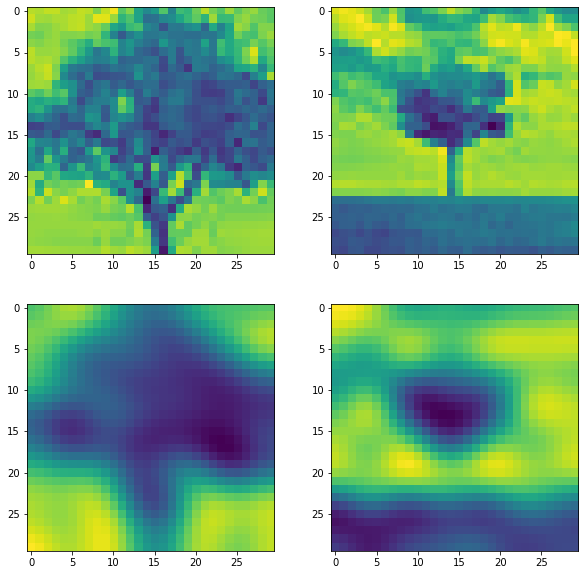

In [32]:
# Show Original/Reconstructed image
fig = plt.figure(figsize = (10, 10))

ax = fig.add_subplot(2, 2, 1)
plt.imshow(img1)

ax = fig.add_subplot(2, 2, 2)
plt.imshow(img2)

ax = fig.add_subplot(2, 2, 3)
plt.imshow(reform1)

ax = fig.add_subplot(2, 2, 4)
plt.imshow(reform2)

In [22]:
np.linalg.norm(img1 - reform1, 'fro') / n

26.265038293488992

In [23]:
130303

130303

In [24]:
imgArr1

array([[213],
       [210],
       [216],
       [216],
       [206],
       [208],
       [216],
       [214],
       [193],
       [216],
       [233],
       [178],
       [196],
       [141],
       [117],
       [134],
       [176],
       [112],
       [167],
       [160],
       [186],
       [213],
       [190],
       [177],
       [203],
       [182],
       [195],
       [202],
       [185],
       [180],
       [220],
       [206],
       [204],
       [208],
       [208],
       [214],
       [215],
       [204],
       [228],
       [227],
       [203],
       [159],
       [174],
       [142],
       [ 93],
       [ 95],
       [115],
       [122],
       [144],
       [163],
       [181],
       [158],
       [205],
       [163],
       [165],
       [193],
       [201],
       [190],
       [187],
       [179],
       [207],
       [195],
       [196],
       [203],
       [207],
       [214],
       [216],
       [204],
       [199],
       [184],
       [145],
      

In [25]:
reform1

array([[175.4736331 , 179.66955868, 186.66274581, 194.13606488,
        199.62064305, 201.24928771, 198.22362416, 190.86395056,
        180.29684452, 167.97711857, 155.27547862, 143.28442478,
        132.85220651, 124.7266047 , 119.64326037, 118.24749854,
        120.85933151, 127.20850888, 136.31268329, 146.61828337,
        156.39600577, 164.24742437, 169.50863914, 172.37148004,
        173.66883692, 174.42668663, 175.39318258, 176.76009084,
        178.19105996, 179.11555085],
       [179.64123582, 182.84498834, 188.06567765, 193.35413053,
        196.67122985, 196.53667292, 192.41055811, 184.69796277,
        174.43860218, 162.8708776 , 151.08472546, 139.89630499,
        129.93862927, 121.84132938, 116.33258202, 114.15475342,
        115.8074221 , 121.24846504, 129.7302627 , 139.89609539,
        150.13637888, 159.07020261, 165.94542379, 170.78007607,
        174.18669883, 176.9707154 , 179.69907732, 182.443027  ,
        184.80541673, 186.19640548],
       [185.33766359, 186.8380

In [26]:
np.linalg.svd(theta)

(array([[ 0.11816777, -0.43259447, -0.14643431, ...,  0.05441352,
         -0.00548591, -0.23333313],
        [-0.00806293,  0.05196091, -0.07349635, ..., -0.03125469,
         -0.04242235, -0.01783892],
        [ 0.00569476,  0.002854  , -0.03725973, ..., -0.01556897,
         -0.0083797 , -0.01600586],
        ...,
        [-0.0175617 ,  0.10640179, -0.11860093, ...,  0.08893275,
         -0.11074018, -0.02116909],
        [-0.01755859,  0.11828568, -0.08647436, ..., -0.03639523,
         -0.09122442,  0.06030366],
        [ 0.05616893,  0.00452376,  0.10116383, ...,  0.12364376,
          0.06131101, -0.23019418]]),
 array([85.19604639, 82.24391227, 71.76708099, 64.65541733, 61.974066  ,
        59.52398102, 56.1254941 , 52.92736719, 49.09654134, 47.96446605,
        47.07522944, 45.59246204, 43.19070699, 40.10310205, 39.01720241,
        38.89715016, 37.61542515, 35.99410692, 35.35480394, 33.18370195,
        32.17948656, 31.36927345, 30.34590186, 29.56513113, 28.69259502,
        

In [27]:
theta.shape

(100, 900)

In [45]:
W.shape[0]

100